In [1]:
import re
import numpy as np
import unicodedata
import pandas as pd
from nltk.util import ngrams
import plotly.graph_objs as go
import plotly.offline as pyoff
import matplotlib.pyplot as plt
from nltk import corpus, stem
from wordcloud import WordCloud, STOPWORDS

# Loading data

In [2]:
training_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

combined_data = pd.concat([training_data, validation_data, test_data])

In [3]:
combined_data.head()

,title,text,subject,date,label
0,It’s Official: #Brexit Has Made The U.K. As R...,"A few days ago, Great Britain voted to walk of...",News,"June 27, 2016",0
1,One French soldier killed in Iraq-Syria area: ...,PARIS (Reuters) - One French soldier from the ...,worldnews,"September 23, 2017",1
2,Texas Governor Directs Violent Threat At Pres...,The lack of respect for the office of the Pres...,News,"January 3, 2016",0
3,‘Responsible Gun Owner’ Who Shot His Girlfrie...,"According to the NRA, good guys with guns ac...",News,"April 25, 2016",0
4,WATCH: Mitt Romney Announces Run for Senate…Ba...,Just what we need another Trump-bashing RINO. ...,politics,16-Feb-18,0


# Label balance

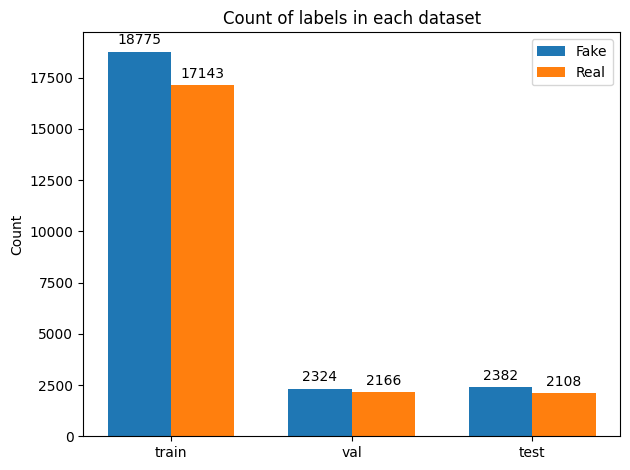

In [4]:
labels = ["train", "val", "test"]
zeros = [training_data.label.value_counts()[0],
         validation_data.label.value_counts()[0],
         test_data.label.value_counts()[0]]
ones = [training_data.label.value_counts()[1],
        validation_data.label.value_counts()[1],
        test_data.label.value_counts()[1]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, zeros, width, label='Fake')
rects2 = ax.bar(x + width / 2, ones, width, label='Real')

ax.set_ylabel('Count')
ax.set_title('Count of labels in each dataset')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Category and label correlation

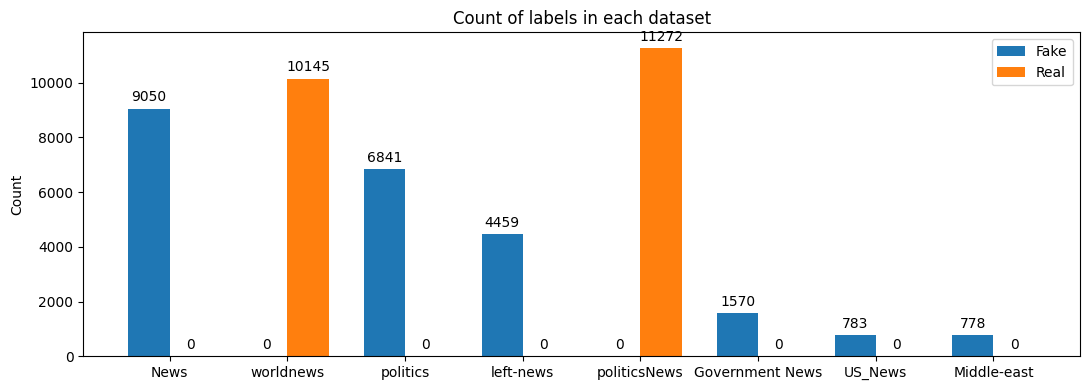

In [5]:
subjects = combined_data.subject.unique().tolist()
fake_subjects = combined_data[combined_data["label"] == 0].subject.unique().tolist()
real_subjects = combined_data[combined_data["label"] == 1].subject.unique().tolist()

zeros = [
    combined_data[combined_data["label"] == 0].subject.value_counts()[subj]
    if subj in fake_subjects else 0
    for subj in subjects
]
ones = [
    combined_data[combined_data["label"] == 1].subject.value_counts()[subj]
    if subj in real_subjects else 0
    for subj in subjects
]

x = np.arange(len(subjects))
width = 0.35

fig, ax = plt.subplots(figsize=(11, 4))

rects1 = ax.bar(x - width / 2, zeros, width, label='Fake')
rects2 = ax.bar(x + width / 2, ones, width, label='Real')

ax.set_ylabel('Count')
ax.set_title('Count of labels in each dataset')
ax.set_xticks(x, subjects)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Sequence lengths

<AxesSubplot:>

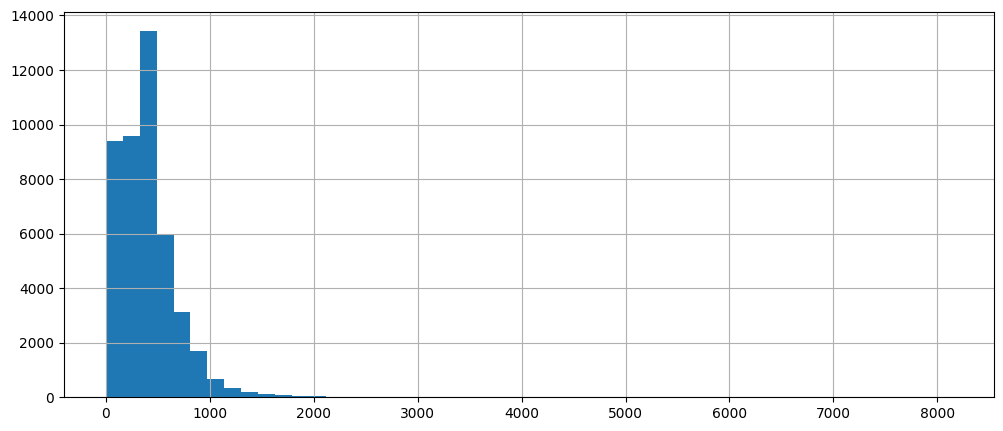

In [6]:
sequence_lengths = combined_data["text"].apply(lambda x: len(x.split()))
sequence_lengths.hist(bins=50, figsize=(12, 5))

# Appearance of words in fake vs real news

In [7]:
def plot_wordcloud(label):
    texts = " ".join(combined_data[combined_data['label'] == label]['text'].to_list()).lower()
    wordcloud = WordCloud(stopwords=STOPWORDS).generate(texts)
    plt.figure(figsize=(13, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

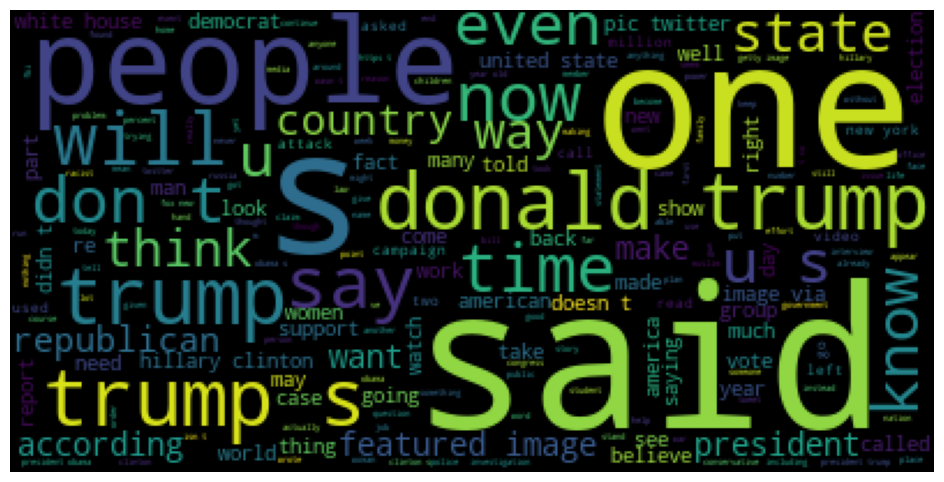

In [8]:
# Fake news
plot_wordcloud(label=0)

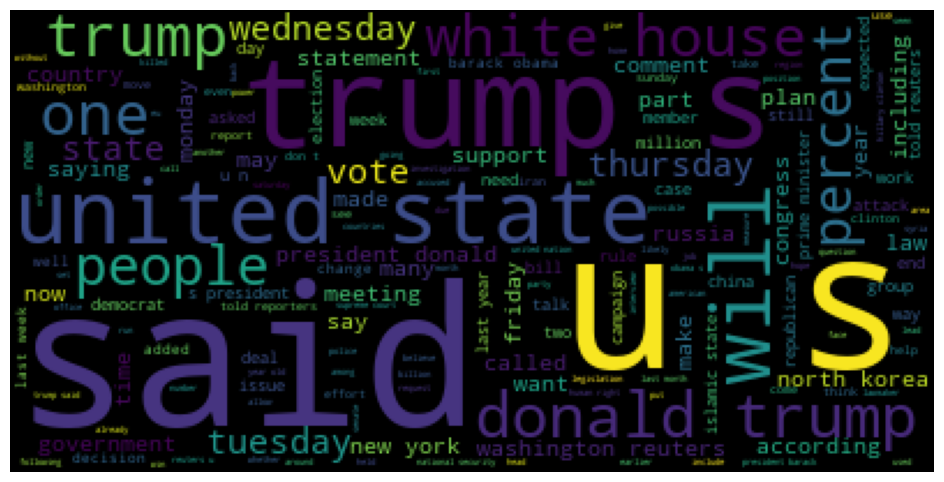

In [9]:
# Real news
plot_wordcloud(label=1)

# n-gram analysis

In [10]:
def process_text(text):
    wnl = stem.WordNetLemmatizer()
    stopwords = corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


fake_texts = process_text(' '.join(str(combined_data[combined_data['label'] == 0]['text'].tolist())))
real_texts = process_text(' '.join(str(combined_data[combined_data['label'] == 1]['text'].tolist())))

KeyboardInterrupt: 

In [ ]:
def get_n_grams(texts, n, top_n):
    n_grams = (pd.Series(ngrams(texts, n)).value_counts())[:top_n]
    n_grams = pd.DataFrame(n_grams)
    n_grams['in'] = n_grams.index
    n_grams['in'] = n_grams.apply(
        lambda x: '(' + x['in'][0] + ', ' + x['in'][1] + ', ' + x['in'][2] + ')', axis=1
    )

In [ ]:
trigram_fake = get_n_grams(fake_texts, 3, 15)
plot_data = [
    go.Bar(
        x=trigram_fake['in'],
        y=trigram_fake[0],
        marker=dict(
            color='Red'
        )
    )
]
plot_layout = go.Layout(
    title='Top 15 tri-grams from Fake News',
    yaxis_title='Count',
    xaxis_title='tri-gram',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
trigram_real = get_n_grams(real_texts, 3, 15)
plot_data = [
    go.Bar(
        x=trigram_real['in'],
        y=trigram_real[0],
        marker=dict(
            color='Green'
        )
    )
]
plot_layout = go.Layout(
    title='Top 30 tri-grams from True News',
    yaxis_title='Count',
    xaxis_title='tri-gram',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)